Colab link: https://colab.research.google.com/drive/1JHFt8bB8_WTAh3oYY_dFX0k7w5p_smq5?usp=sharing.

# Scientific context of the problem

The problem is presented at https://challengedata.ens.fr/challenges/122 and proposed by the chemistry department of ENS (Pablo MAS and Rodolphe Vuilleumier).
We propose in this notebook to build a simple algorithm based on these data using decision trees and random forest.

# The data

The dataset is made of the SMILES (simplified molecular-input line-entry system) text description of 4400 molecules. It is possible to work directly with this format but it is also possible to convert SMILES into molecular graphs or molecular fingerprints.
Fingerprints are binary vectors that capture the presence or absence of specific chemical features, such as functional groups, atom types, bonds, or molecular properties. It is the most common way to encode the chemical information contained in a molecule and that is the approach used in the introduction notebook to get the baseline score.

1. What is the machine learning family this problem is about? What is the nature of the input data?

2. Enumerate some methods that could be used for such a task.

# Prerequisites

3. Import the necessary packages, in particular, we will use:
> * [`matplotlib`](https://matplotlib.org/) for data visualisation and plots,
> * [`numpy`](https://numpy.org/) for standard numerical operations and algebra,
> * [`pandas`](https://pandas.pydata.org/) for data analysis,
> * [`scikit-learn`](https://scikit-learn.org/stable/) for ML algorithms and related functions used for model selection or data pre-processing.
> * [`rdkit`](https://www.rdkit.org/docs/GettingStartedInPython.html) to transform the text descriptions into fingerprints (vector representations).


In [ ]:
import pandas                       # For data management
import matplotlib.pyplot as plt     # For plotting
import matplotlib as mpl            # For plotting setup
import numpy as np                  # For numerical calculations
import sklearn                      # Machine learning library
from sklearn import model_selection
from sklearn import metrics

!pip install rdkit

# For fingerprints
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem

# Formatting the plots
plt.rcParams['figure.figsize'] = [6,6]
plt.rcParams['font.size'] = 18
plt.rcParams['font.weight'] = 'normal'
plt.style.use('default')
mpl.rcParams['mathtext.fontset'] = 'cm'
mpl.rcParams['mathtext.rm'] = 'serif'
mpl.rcParams['font.size'] = 22
mpl.rcParams['axes.formatter.limits'] = (-6, 6)
mpl.rcParams['axes.formatter.use_mathtext'] = True
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
mpl.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
mpl.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True

4. To download the training dataset, you can get it from [my Github](https://github.com/tbonnair/Machine-Learning-Principles-with-Applications-in-Physics) or directly from the [ChallengeData website](https://challengedata.ens.fr/challenges/122) by creating an account.

In [ ]:
!git clone https://github.com/tbonnair/ENS_AI_Chemistry.git/

fatal: destination path 'ENS_AI_Chemistry' already exists and is not an empty directory.


# Loading, exploring, and preparing the data

5. Load the data ($X_\mathrm{train}$ and $y_\mathrm{train}$) using the `pandas` package.

In [ ]:
Xpath = 'ENS_AI_Chemistry/Hands-on/Data/X_train.csv'
ypath = 'ENS_AI_Chemistry/Hands-on/Data/y_train.csv'
X_dataset = pandas.read_csv(Xpath, index_col=0)
y_dataset = pandas.read_csv(ypath, index_col=0)

6. Explore the data (how many molecules are there, how the data look like, etc.) using the `pandas` library. To do so, you can use the .head() and .info() functions.


In [ ]:
X_dataset.head(5)

,smiles
id,
0,CNC(=O)c1ccccc1Sc1ccc2c(C#Cc3cccc(NCCOC)c3)n[n...
1,CC(C)(C)c1ccc(Nc2nnc(-c3cnccc3CCc3ccncc3)o2)cc1
2,CN1CCN(CCCn2ccc(-c3cnc4c(-c5ccsc5)cnn4c3)cc2=O...
3,CCn1c2ccc(NC(=O)Nc3ccc(OC)cc3)cc2c2c3c(c4c(c21...
4,Cc1ccc(C(=O)Nc2cccc(C(C)C)c2)cc1N1CCc2ncncc2C1


In [ ]:
X_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4400 entries, 0 to 4399
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smiles  4400 non-null   object
dtypes: object(1)
memory usage: 68.8+ KB


You can also have a look at the distribution of pIC50 in the training set, the quantity we aim to predict based on the text description.

Text(0, 0.5, 'Count')

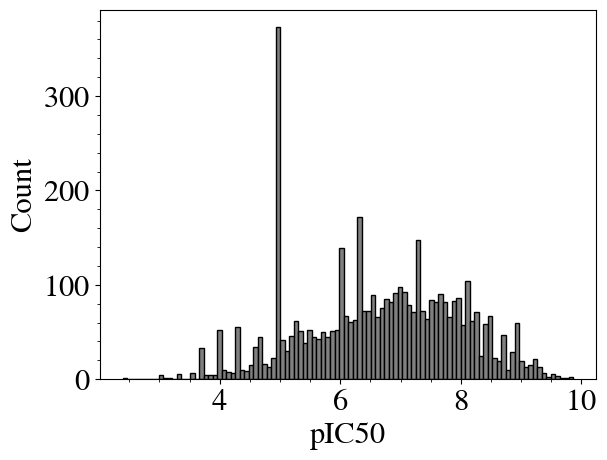

In [ ]:
histogram = plt.hist(y_dataset, 100, fc='grey', ec='k')
plt.xlabel(r'pIC50')
plt.ylabel(r'Count')

8. Using the rdkit package, we will first transform the data from their text (SMILES) description into vectors using 512 bits and a radius of 3. For an explanation of the Morgan fingerprints, you can have a look [here](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).

In [ ]:
# Convert Mol to fingerprints
train_mols = [AllChem.MolFromSmiles(smile) for smile in X_dataset['smiles']]
nbits = 128  # For the benchmark a number of 2048 bits was used
rad = 3
train_fps = np.array([AllChem.GetMorganFingerprintAsBitVect(mol, radius=rad, nBits=nbits) for mol in train_mols])

In [ ]:
print(train_fps)

[[0 1 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 0 ... 1 0 0]
 [1 0 1 ... 0 0 0]
 [1 0 0 ... 1 0 0]]


The dataset is now a vector composed of 4400 vectos of one and zero of size 1024. A one means that there is a specific feature present in the SMILE description, while a 0 means it is not. These are the data we'll use in this notebook.

8. Arange the data into a feature matrix $\boldsymbol{X}$ and a target vector $\boldsymbol{y}$. Then, prepare the dataset and split it into 80% training and 20% validation using the scikit-learn [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.

In [ ]:
# @title
# First let's split the dataset into X and y (matrix and vector) as in the lectures
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(train_fps, y_dataset, test_size=0.2, random_state=102)

print(len(X_train))
print(len(X_valid))

3520
880


Now the data are ready to be used for learning!

# A first model: decision tree

Now the data are ready to be used for training, let us build a first model: a decision tree.

9. Using the scikit-learn documentation, find how to fit a Decision Tree with a maximum depth of 15 and using the absolute error on the training dataset.

In [ ]:
# @title
from sklearn import tree

DT = tree.DecisionTreeRegressor(max_depth=15, criterion='absolute_error')
DT.fit(X_train, y_train)

10. Test your model on the validation dataset and look at the obtained score.

In [ ]:
# @title
y_pred = DT.predict(X_valid)
print(metrics.mean_absolute_error(y_pred, y_valid))

0.9203694224036496


11. Tune the hyperparameter of the maximum depth. To this end, you can use the validation set we have prepared at the beginning. Find the hyperparameter having the best score on this set with depth in the range [1, 20].

100%|██████████| 19/19 [00:57<00:00,  3.00s/it]


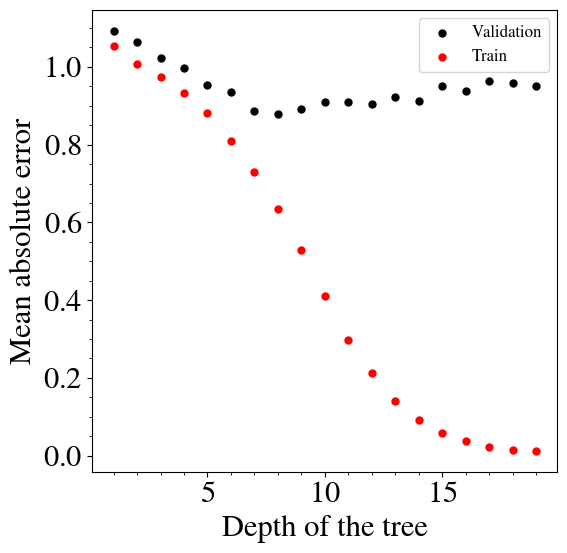

In [ ]:
# @title
from tqdm import tqdm   # To show loading bar

depths = np.arange(1, 20, 1)

scores_validation = []
scores_training = []
for d in tqdm(depths):
  DT = tree.DecisionTreeRegressor(max_depth=d, criterion='absolute_error')
  DT.fit(X_train, y_train)

  # MAE train
  y_pred_train = DT.predict(X_train)
  MAE_train = metrics.mean_absolute_error(y_pred_train, y_train)

  # MAE validation
  y_pred_valid = DT.predict(X_valid)
  MAE_valid = metrics.mean_absolute_error(y_pred_valid, y_valid)

  # Save scores
  scores_training.append(MAE_train)
  scores_validation.append(MAE_valid)

# Plot
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(depths, scores_validation, s=25, color='k', label=r'Validation')
ax.scatter(depths, scores_training, s=25, color='r', label=r'Train')
ax.set_xlabel(r'Depth of the tree')
ax.set_ylabel(r'Mean absolute error')
ax.legend(frameon=True, fontsize=12)

12. Intepret the evolution of the validation score when varying the maximum depth: how does the validation error behaves and why? (To help you, you can also store and visualise the evolution of the training error in addition to validation error.)

# Improving the model with more trees: random forest

13. Remind the principle behind random forests.


14. Using the scikit-learn documentation, fit a random forest to the training data with a number of trees of 20 and a maximum depth of 15. Compare this setup with our first decision tree.

In [ ]:
# @title
from sklearn.ensemble import RandomForestRegressor

RF = RandomForestRegressor(n_estimators=20, max_depth=15, criterion='squared_error')

RF.fit(X_train, y_train)

y_valid_pred = RF.predict(X_valid)

print(metrics.mean_absolute_error(y_valid_pred, y_valid))

<ipython-input-88-41c25415945e>:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF.fit(X_train, y_train)


0.7329883870921189


15. Repeat the hyperparameter tuning for tuning the number of trees in [1, 50] at fixed maximum depth = 15 to find the best random forest model for our data.

In [ ]:
# @title
from tqdm import tqdm   # To show loading bar

ntrees = [1, 2, 4, 8, 10, 15, 20, 25, 30, 35, 40, 50]
print(ntrees)

scores_generalization_RF = []
scores_training_RF = []
for n in tqdm(ntrees):
  RF_valid = RandomForestRegressor(n_estimators=n, max_depth=15, criterion='squared_error')
  RF_valid.fit(X_train, np.array(y_train).squeeze())

  y_train_pred = RF_valid.predict(X_train)
  train_score = metrics.mean_absolute_error(y_train_pred, y_train)

  y_valid_pred = RF_valid.predict(X_valid)
  valid_score = metrics.mean_absolute_error(y_valid_pred, y_valid)

  scores_training_RF.append(train_score)
  scores_generalization_RF.append(valid_score)

[1, 2, 4, 8, 10, 15, 20, 25, 30, 35, 40, 50]


 92%|█████████▏| 11/12 [00:15<00:02,  2.31s/it]

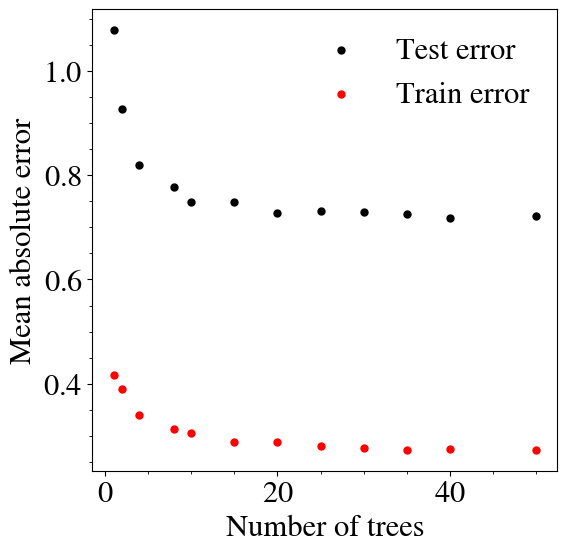

In [ ]:
# @title
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(ntrees, scores_generalization_RF, s=25, color='k', label=r'Test error')
ax.scatter(ntrees, scores_training_RF, s=25, color='r', label=r'Train error')
ax.set_xlabel(r'Number of trees')
ax.set_ylabel(r'Mean absolute error')
ax.legend(frameon=False)

16. Does the curve showing the evolution of the test error look the same as previously with the decision tree depth? Why?

# Going further

Now it's your turn to go further and try to beat the benchmark proposed by Pablo. He obtained a MAE of 0.5388 on the test set (that you have not access to, it is hosted on the website) using 2048 bits for the fingerprints and a random forest. For this, you can try to finetune the hyperparameters, to build new models (boosting, neural networks, etc.). The goal is that you learn how to build and compare models, recognise overfitting, etc. and orally present in January the results you obtained, and how you obtained it (the methodology you followed, the papers you were inspired by, etc.)

## Randomized search for hyperparameter tuning
In our examples, we always focus on one hyperparameter at a time. In fact, using scikit-learn you can specify several ranges for your hyperparameters and test them randomly to find the association of parameters using randomized search or grid search cross-validation. Randomized search is more efficient numerically but is not leading you to the best possible set of parameters, while grid search consists in an exhaustive search in your pre-defined ranges for parameters. Here we illustrate it with randomized search.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# define range of values for each hyperparameter
hyperparameters_range = [{
        "n_estimators": [1, 5, 10, 20, 40],       # Number of trees
        "max_features": [0.5, 1.0, "sqrt", "log2"],  # Proportion of the features used for training you RFs
        "max_depth": [5, 10, 15, 20],  # Maximum depth of the trees trained in RFs
    }]

# Create a base model
RF = RandomForestRegressor(n_estimators=20, max_depth=15, n_jobs=-1)

# Random search with cross validation
RF_CV = RandomizedSearchCV(
    RF, param_distributions=hyperparameters_range, cv=5)

# Fit the search
RF_CV.fit(X_train, np.array(y_train).squeeze())

You can now select the best model and test it.

In [ ]:
print(RF_CV.best_params_)         # Prints the best parameters
RF_best = RF_CV.best_estimator_   # Select the best model
RF_best.score(X_valid, y_valid)     # Test dataset

{'n_estimators': 40, 'max_features': 0.5, 'max_depth': 20}


0.5270072412314701

You could do similarly with the [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) function from scikit-learn to perform grid search cross-validation for tuning your hyperparameters.